In [105]:
import geopandas as gpd
import pandas as pd
import numpy as np
from math import pi
import folium
%matplotlib inline
import shapely
import time
from shapely.geometry import *
import pysal as ps
from datetime import datetime
import matplotlib.pylab as plt

In [2]:
blocks = gpd.read_file('Oakland_Blocks.shp').set_index('GEOID10')['geometry']

In [3]:
fips = ['060014010002001','060014010002002','060014010002010','060014010002012','060014010002003','060014010002011']
test1=blocks.loc[fips]
test1bg=test1.groupby(test1.index.str[:12]).agg(shapely.ops.unary_union)

test2fips=['060014013002004','060014013002009','060014013002007','060014013002005','060014013002002',
           '060014013002006','060014013002003',
           '060014013002008','060014013002000']
test2=blocks.loc[test2fips]
test2bg=test2.groupby(test2.index.str[:12]).agg(shapely.ops.unary_union)

test3fips=['060014010005008', '060014010005010', '060014010006011']
test3=blocks.loc[test3fips]
test3bg=test3.groupby(test3.index.str[:12]).agg(shapely.ops.unary_union)

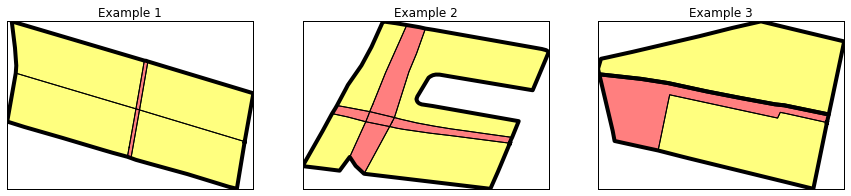

In [4]:
f, axes = plt.subplots(1,3, figsize=(15,3))
for i,(result, ax, bg) in enumerate(zip([test1, test2, test3], axes, [test1bg, test2bg, test3bg])):
    t=(result.area/result.length)>16
    a,b=result[t], result[~t]
    ax.set(xticks=[], yticks=[], title='Example {}'.format(str(i+1)))
    gpd.GeoSeries(bg).plot(ax=axes[i], linewidth=4, color='white')
    a.plot(ax=axes[i], color='yellow')
    b.plot(ax=axes[i], color='red')


In [5]:
#in addition to blocks, have truth input sequence and grouping

sliver_merge_mask = np.log(blocks.area/blocks.length)<2.9
bg_grouping = pd.Series(index=blocks.index, data=blocks.index.str[:12], name='BGFIPS')


In [96]:
#want to get the indices of those that merge after multiple times?

def merge_polys(input_geos, merge_mask=sliver_merge_mask, constrain_groups=bg_grouping, max_iterations=5, no_print=True):
    
    def merge_polys_a(input_geos, merge_mask=sliver_merge_mask, constrain_groups=bg_grouping):
        merge_polys = input_geos[merge_mask]
        full_polys = input_geos[~merge_mask]
        def gen_xwalk(poly):
            i=poly.name
            geo=poly.geometry
            if merge_mask.loc[i]:
                intersections = full_polys.intersection(geo)
                line_intersections = intersections.apply(lambda x:type(x)).isin([LineString, MultiLineString])
                touching = full_polys[line_intersections]
                try:
                    cg = constrain_groups.loc[intersections.index]
                    in_same_group = cg==constrain_groups.loc[i]
                    possible_polys = full_polys[in_same_group & line_intersections]
                except:
                    possible_polys = full_polys[line_intersections]

                if len(possible_polys)>0:
                    return intersections.loc[possible_polys.index].length.idxmax()
                else:
                    return i
            else:
                return i
        poly_xwalk = pd.Series(pd.DataFrame(input_geos).apply(gen_xwalk,1), name='XWalk')
        merged_geo = gpd.GeoSeries(input_geos.groupby(poly_xwalk).agg(shapely.ops.unary_union), crs=input_geos.crs)
        return poly_xwalk, merged_geo
    
    
    count=1
    xwalk, new_geo = merge_polys_a(input_geos, merge_mask = merge_mask, constrain_groups=constrain_groups)
    #o_xwalk = xwalk.copy()
    if not no_print: print '{} slivers remain after {} iteration{}'.format(merge_mask[new_geo.index].sum(), \
                                                              1, "s" if count>1 else '')
    
    if merge_mask[new_geo.index].any():
        while merge_mask[new_geo.index].any():          
            if count<max_iterations or not max_iterations:
                xwalk2,new_geo = merge_polys_a(new_geo, merge_mask = merge_mask, constrain_groups=constrain_groups)
                xwalk.update(xwalk2)
                count+=1
                if not no_print:
                    print '{} slivers remain after {} iteration{}'.format(merge_mask[new_geo.index].sum(), \
                                                              count, "s" if count>1 else '')
            else:
                break
        #xwalk.update(xwalk2)
    #print "All slivers dissolved in {} iteration{}".format(count, "s" if count>1 else '')
    
    return xwalk, new_geo
    

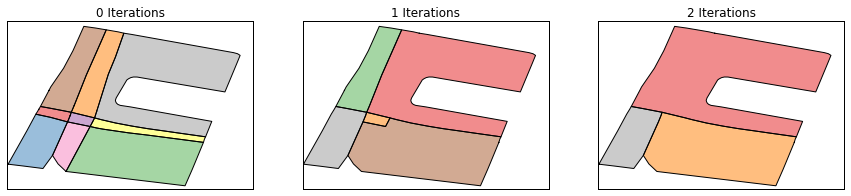

In [80]:
f, axes = plt.subplots(1,3, figsize=(15,3))
test2.plot(ax=axes[0])
merge_polys(test2, max_iterations=1)[1].plot(ax=axes[1])
merge_polys(test2)[1].plot(ax=axes[2])
for i, ax in enumerate(axes):
    ax.set(xticks=[], yticks=[], title='{} Iterations'.format(i))


In [101]:
_a = datetime.now()

block_xwalk, block_new_geo = =merge_polys(blocks, merge_mask=sliver_merge_mask, constrain_groups=bg_grouping, no_print=False)

_b=datetime.now()
print _b-_a

224 slivers remain after 1 iteration
219 slivers remain after 2 iterations
217 slivers remain after 3 iterations
217 slivers remain after 4 iterations
217 slivers remain after 5 iterations
224 slivers remain after 1 iteration
219 slivers remain after 2 iterations
217 slivers remain after 3 iterations
217 slivers remain after 4 iterations
217 slivers remain after 5 iterations
224 slivers remain after 1 iteration
219 slivers remain after 2 iterations
217 slivers remain after 3 iterations
217 slivers remain after 4 iterations
217 slivers remain after 5 iterations
224 slivers remain after 1 iteration
219 slivers remain after 2 iterations
217 slivers remain after 3 iterations
217 slivers remain after 4 iterations
217 slivers remain after 5 iterations
1 loop, best of 3: 40.1 s per loop
